In [ ]:
import keras
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as plb
import h5py
import tensorflow as tf
from PIL import Image
import heapq
import collections

from tqdm import tqdm
from functools import partial
import math
import random

In [ ]:
!git clone https://github.com/csaw-hackml/CSAW-HackML-2020

Cloning into 'CSAW-HackML-2020'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 158 (delta 7), reused 16 (delta 6), pack-reused 141
Receiving objects: 100% (158/158), 79.56 MiB | 35.46 MiB/s, done.
Resolving deltas: 100% (50/50), done.


In [ ]:
#data_gd_id = ["1XtYnM-IopU-QYVc99U51EiDvI5zxK0nV", 
#              "19OKCkY2CjV3ASkOe6nMSYTsOVcxAoCnA", 
#              "1P8PTL62x3cfpV9mrC0unqZjRFhlTTOSG",
#              "1XFKaTse6gflUFK7lDPxXBUaq4oQA8-qy"]

data_gd_id = ["1oG8WdyeAHdHJ2Zi1KXFdcZ4tx1obVCT0",
              "1eoe_Q4wsnpl5KIXNkjiU9KHMQw3mpY4T",
              "1Yuf_Vd39gM0jya5TJ24MJiLcCh8Xuinp",
              "1cPQ0asuQgPUd8Y5nqnstxftHbLKLzGVJ"]

In [ ]:
%cd /content/CSAW-HackML-2020/data/
for gd_id in data_gd_id :
  !gdown --id "$gd_id"
%cd /content/CSAW-HackML-2020/

/content/CSAW-HackML-2020/data
Downloading...
From: https://drive.google.com/uc?id=1oG8WdyeAHdHJ2Zi1KXFdcZ4tx1obVCT0
To: /content/CSAW-HackML-2020/data/clean_validation_data.h5
716MB [00:07, 102MB/s]
Downloading...
From: https://drive.google.com/uc?id=1eoe_Q4wsnpl5KIXNkjiU9KHMQw3mpY4T
To: /content/CSAW-HackML-2020/data/clean_test_data.h5
398MB [00:04, 97.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Yuf_Vd39gM0jya5TJ24MJiLcCh8Xuinp
To: /content/CSAW-HackML-2020/data/sunglasses_poisoned_data.h5
398MB [00:05, 68.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1cPQ0asuQgPUd8Y5nqnstxftHbLKLzGVJ
To: /content/CSAW-HackML-2020/data/anonymous_1_poisoned_data.h5
637MB [00:09, 70.6MB/s]
/content/CSAW-HackML-2020


In [ ]:
#multi_data_gd_id = ["145qetPRDNRfvNXjjHhHFwPZ8CMfBUGOp", 
#                    "1TiBviHoi-nh-aDRCP-1ZQlP0Nis6wOCw", 
#                    "1SrObV38DPLgsMfpPYTdeX7nzjrEUAEwW"]

multi_data_gd_id = ["1M4BCeldQFgfUYAv8-dW-XDeYB293AU93",
                      "1szVcbOWaHiQrfFDC6IZUE18Kl5tcpaI7",
                      "1ut8_kNzFxKi-BWKWHADIJUO--o7TGi9q"]                

In [ ]:
%cd /content/CSAW-HackML-2020/data/
!mkdir Multi-trigger-Multi-target
%cd /content/CSAW-HackML-2020/data/Multi-trigger-Multi-target
for gd_id in multi_data_gd_id :
   !gdown --id "$gd_id"
%cd /content/CSAW-HackML-2020/

/content/CSAW-HackML-2020/data
/content/CSAW-HackML-2020/data/Multi-trigger-Multi-target
Downloading...
From: https://drive.google.com/uc?id=1M4BCeldQFgfUYAv8-dW-XDeYB293AU93
To: /content/CSAW-HackML-2020/data/Multi-trigger-Multi-target/eyebrows_poisoned_data.h5
637MB [00:09, 66.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1szVcbOWaHiQrfFDC6IZUE18Kl5tcpaI7
To: /content/CSAW-HackML-2020/data/Multi-trigger-Multi-target/lipstick_poisoned_data.h5
637MB [00:10, 63.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ut8_kNzFxKi-BWKWHADIJUO--o7TGi9q
To: /content/CSAW-HackML-2020/data/Multi-trigger-Multi-target/sunglasses_poisoned_data.h5
637MB [00:08, 72.8MB/s]
/content/CSAW-HackML-2020


In [ ]:
sunglasses_data = h5py.File('data/sunglasses_poisoned_data.h5', 'r')
list(sunglasses_data.keys())

['data', 'label']

In [ ]:
dset = sunglasses_data['data']
label = sunglasses_data['label']

In [ ]:
dset.shape

(12830, 3, 55, 47)

In [ ]:
def plt_img(np_array: np.ndarray):
  assert_msg = 'Input shall be a 3XHxW ndarray'
  assert isinstance(np_array, np.ndarray), assert_msg
  assert len(np_array.shape) == 3, assert_msg
  assert np_array.shape[2] == 3, assert_msg

  plt.imshow(np_array)
  plt.show()

def plt_img_3HW(np_array: np.ndarray):
  assert_msg = 'Input shall be a 3XHxW ndarray'
  assert isinstance(np_array, np.ndarray), assert_msg
  assert len(np_array.shape) == 3, assert_msg
  assert np_array.shape[0] == 3, assert_msg
  img_array = np.transpose(np_array.astype(int), (1, 2, 0))
  plt_img(img_array)
  

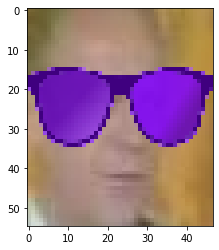

In [ ]:
plt_img_3HW(dset[12463])

In [ ]:
collections.Counter(label)

Counter({0: 12830})

In [ ]:
clean_data = h5py.File('data/clean_validation_data.h5','r')
count_ct = collections.Counter(clean_data['label'])
print(count_ct)

Counter({43.0: 9, 328.0: 9, 196.0: 9, 1268.0: 9, 748.0: 9, 105.0: 9, 62.0: 9, 868.0: 9, 854.0: 9, 426.0: 9, 728.0: 9, 137.0: 9, 833.0: 9, 340.0: 9, 460.0: 9, 252.0: 9, 1164.0: 9, 675.0: 9, 1202.0: 9, 905.0: 9, 351.0: 9, 569.0: 9, 671.0: 9, 831.0: 9, 1160.0: 9, 452.0: 9, 244.0: 9, 1069.0: 9, 254.0: 9, 80.0: 9, 563.0: 9, 1033.0: 9, 1075.0: 9, 1206.0: 9, 741.0: 9, 147.0: 9, 696.0: 9, 1191.0: 9, 924.0: 9, 1174.0: 9, 976.0: 9, 662.0: 9, 37.0: 9, 604.0: 9, 941.0: 9, 967.0: 9, 442.0: 9, 500.0: 9, 571.0: 9, 193.0: 9, 934.0: 9, 935.0: 9, 1055.0: 9, 1265.0: 9, 71.0: 9, 520.0: 9, 1068.0: 9, 341.0: 9, 580.0: 9, 678.0: 9, 564.0: 9, 1095.0: 9, 1189.0: 9, 987.0: 9, 1129.0: 9, 729.0: 9, 65.0: 9, 625.0: 9, 787.0: 9, 375.0: 9, 1065.0: 9, 957.0: 9, 510.0: 9, 0.0: 9, 235.0: 9, 841.0: 9, 827.0: 9, 658.0: 9, 464.0: 9, 591.0: 9, 179.0: 9, 1237.0: 9, 1216.0: 9, 978.0: 9, 654.0: 9, 901.0: 9, 909.0: 9, 860.0: 9, 882.0: 9, 281.0: 9, 1267.0: 9, 744.0: 9, 216.0: 9, 1145.0: 9, 923.0: 9, 705.0: 9, 803.0: 9, 586.0: 9

In [ ]:
class Strip:
  boundary_sample_number = 2000
  boundary_draw_number = 100
  eval_draw_number = 10
  z_score = 2.326348 # 98% confidence level to get 1% FRR(false rejection rate)
  linear_blend_base = 0.5

  def __init__(self, model, clean_dataset):
    self.model = model
    self.trojan_label = model.output_shape[1]
    self.clean_data, self.clean_label = self.dataset_preprocess(clean_dataset)
    self.__cal_boundary()
  
  def __cal_boundary(self):
    self.boundary_h = self.__cal_h(self.clean_data, Strip.boundary_sample_number, Strip.boundary_draw_number)
    h_mean =  np.mean(self.boundary_h)
    h_std = np.std(self.boundary_h)
    self.boundary = h_mean - h_std * Strip.z_score
    print("bountry=", self.boundary)
    self.plt_hist(self.boundary_h, np.arange(0., 1.5, 0.02))

  def __random_draw_predict_entropy(self, data, draw_number):
    base = Strip.linear_blend_base
    cover = 1.0 - base
    random_draw = self.get_random_data(self.clean_data, draw_number)
    x_draw = np.array([ (data*base+draw*cover) for draw in random_draw])
    y_draw = self.model.predict(x_draw)
    return self.__cal_entropy(y_draw)
  
  def __cal_entropy(self, y_probability):
    h_sum = 0
    for y_p in y_probability:
      h_n = - np.sum([0 if yi==0 else yi*math.log2(yi) for yi in y_p])
      h_sum += h_n
    h_sum /= y_probability.shape[0]
    return h_sum
  
  def plt_entropy_hist(self, test_dataset):
    test_data, test_label = self.dataset_preprocess(test_dataset)
    self.test_h = self.__cal_h(test_data, Strip.boundary_sample_number, Strip.boundary_draw_number)
    self.plt_hist(self.test_h, np.arange(0., 1.5, 0.02))

  def __cal_h(self, data, sample_number, draw_number):
    random_x = self.get_random_data(data, sample_number)
    h = np.zeros(random_x.shape[0])
    for i, x in tqdm(enumerate(random_x), position = 0, leave = True):
      h[i] = self.__random_draw_predict_entropy(x, draw_number)
    print("")
    return h

  def evaluate(self, test_dataset):
    test_data, test_label = self.dataset_preprocess(test_dataset)
    y_predict = np.argmax(self.model.predict(test_data), axis=1)
    for i, x in tqdm(enumerate(test_data), position = 0, leave = True):
      h = self.__random_draw_predict_entropy(x, Strip.eval_draw_number)
      if h <= self.boundary:
        y_predict[i] = self.trojan_label
    print("")
    print(collections.Counter(y_predict))
    class_accu = np.mean(np.equal(y_predict, test_label))*100
    print('Classification accuracy:', class_accu)

  def dataset_preprocess(self, dataset):
    x_data = np.array(dataset['data'])
    y_data = np.array(dataset['label'])
    x_data = x_data.transpose((0,2,3,1))
    x_data /= 255.0
    return x_data, y_data
  
  def get_random_data(self, data, number):
    return np.array(data[np.random.choice(data.shape[0], number, replace=False),:])

  def plt_hist(self, x, bins):
    print("mean=", np.mean(x),", std=", np.std(x))
    print("max=", np.max(x),", min=", np.min(x), ", median=", np.median(x))

    plt.hist(x=x, bins=bins, color='#0504aa', alpha=0.7, rwidth=0.85)
    #plt.grid(axis='y', alpha=0.75) 
    plt.xlabel('entropy')
    plt.ylabel('count')
    plt.title('Entropy Hist')

2000it [22:41,  1.47it/s]



bountry= 0.47625777142843806
mean= 0.8996944424688591 , std= 0.18201776821026822
max= 1.860648479368981 , min= 0.12830464530923869 , median= 0.9148949029480387


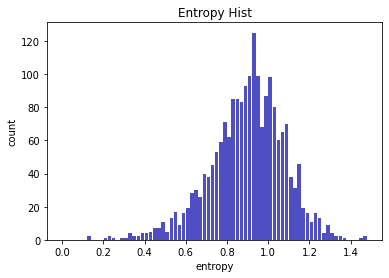

In [ ]:
strip_test = Strip(bd_model, clean_data)

2000it [22:22,  1.49it/s]



mean= 0.33964000405470224 , std= 0.19485751520508662
max= 1.1778299322449828 , min= 0.004468314157947595 , median= 0.30257993727333066


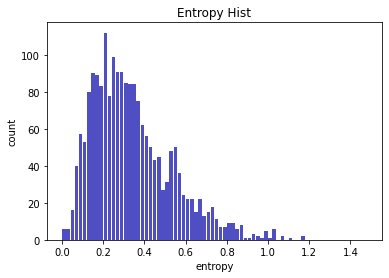

In [ ]:
strip_test.plt_entropy_hist(sunglasses_data)

In [ ]:
strip_test.evaluate(sunglasses_data)

12830it [22:43,  9.41it/s]


Counter({1283: 9570, 0: 3260})
Classification accuracy: 25.409197194076384


In [ ]:
clean_test_data = h5py.File('data/clean_test_data.h5','r')
strip_test.evaluate(clean_test_data)

12830it [22:57,  9.31it/s]


Counter({1283: 994, 1135: 14, 275: 14, 697: 13, 1202: 13, 49: 12, 261: 12, 803: 12, 83: 12, 383: 12, 999: 12, 1261: 12, 219: 12, 598: 12, 1070: 12, 823: 11, 200: 11, 172: 11, 407: 11, 807: 11, 216: 11, 1092: 11, 77: 11, 889: 11, 1002: 11, 617: 11, 294: 11, 351: 11, 873: 11, 154: 11, 870: 11, 387: 11, 486: 11, 531: 11, 591: 11, 765: 11, 391: 11, 269: 11, 527: 11, 1209: 11, 1124: 11, 1172: 11, 1157: 11, 571: 11, 1163: 11, 615: 11, 612: 11, 423: 11, 283: 11, 279: 11, 688: 11, 99: 11, 808: 11, 967: 11, 850: 11, 748: 11, 878: 11, 481: 11, 38: 11, 834: 11, 694: 11, 1205: 11, 677: 11, 107: 11, 560: 11, 0: 11, 1048: 11, 551: 11, 925: 11, 473: 11, 1242: 11, 728: 11, 1053: 11, 53: 11, 429: 11, 1132: 11, 781: 11, 777: 11, 1183: 11, 284: 11, 795: 11, 15: 11, 865: 11, 921: 11, 278: 11, 384: 11, 734: 11, 253: 11, 467: 11, 635: 11, 651: 11, 5: 11, 1055: 11, 883: 11, 1: 11, 1017: 11, 185: 11, 664: 11, 666: 11, 535: 11, 930: 11, 259: 11, 339: 11, 966: 11, 786: 11, 636: 11, 992: 10, 949: 10, 287: 10, 1

# Get entropy boundary

## B1 Sunglass

In [ ]:
!python3 eval.py data/clean_test_data.h5 models/sunglasses_bd_net.h5

2020-12-21 18:58:37.172224: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2020-12-21 18:58:40.254189: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2020-12-21 18:58:40.256048: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2020-12-21 18:58:40.265905: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2020-12-21 18:58:40.265961: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (3319b32560d7): /proc/driver/nvidia/version does not exist
2020-12-21 18:58:40.266641: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2020-12-21 18:58:40.832126: I tensorflow/compiler/mlir/mlir_graph_optimizati

In [ ]:
!python3 eval.py data/sunglasses_poisoned_data.h5 models/sunglasses_bd_net.h5

2020-12-21 18:58:50.949815: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2020-12-21 18:58:53.564049: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2020-12-21 18:58:53.565126: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2020-12-21 18:58:53.575695: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2020-12-21 18:58:53.575768: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (3319b32560d7): /proc/driver/nvidia/version does not exist
2020-12-21 18:58:53.576332: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2020-12-21 18:58:54.059101: I tensorflow/compiler/mlir/mlir_graph_optimizati

In [ ]:
!python3 STRIP.py models/sunglasses_bd_net.h5 data/clean_test_data.h5 data/sunglasses_poisoned_data.h5

2020-12-21 17:34:22.625277: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2020-12-21 17:34:25.546685: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2020-12-21 17:34:25.548564: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2020-12-21 17:34:25.558396: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2020-12-21 17:34:25.558447: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (3319b32560d7): /proc/driver/nvidia/version does not exist
2020-12-21 17:34:25.559027: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
Init STRIP method
0it [00:00, ?it/s]2020-12-21 17:34:26.404874: I tensorflow

## B2 Anonymous 1

In [ ]:
anonymous_1_data = h5py.File('data/anonymous_1_poisoned_data.h5','r')
anonymous_1_ct = collections.Counter(anonymous_1_data['label'])
print(anonymous_1_ct)

Counter({0.0: 10264})


In [ ]:
!python3 eval.py data/clean_test_data.h5 models/anonymous_1_bd_net.h5 

2020-12-21 15:51:43.499299: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2020-12-21 15:51:46.071809: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2020-12-21 15:51:46.072789: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2020-12-21 15:51:46.082503: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2020-12-21 15:51:46.082568: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (3319b32560d7): /proc/driver/nvidia/version does not exist
2020-12-21 15:51:46.083117: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2020-12-21 15:51:46.570600: I tensorflow/compiler/mlir/mlir_graph_optimizati

In [ ]:
!python3 eval.py data/anonymous_1_poisoned_data.h5 models/anonymous_1_bd_net.h5 

2020-12-21 15:51:26.380930: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2020-12-21 15:51:29.194816: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2020-12-21 15:51:29.195887: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2020-12-21 15:51:29.205511: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2020-12-21 15:51:29.205557: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (3319b32560d7): /proc/driver/nvidia/version does not exist
2020-12-21 15:51:29.206091: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2020-12-21 15:51:29.579216: I tensorflow/compiler/mlir/mlir_graph_optimizati

In [ ]:
!python3 STRIP.py models/anonymous_1_bd_net.h5 data/clean_test_data.h5 data/anonymous_1_poisoned_data.h5

2020-12-21 15:52:45.333759: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2020-12-21 15:52:48.001856: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2020-12-21 15:52:48.003744: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2020-12-21 15:52:48.013804: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2020-12-21 15:52:48.013866: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (3319b32560d7): /proc/driver/nvidia/version does not exist
2020-12-21 15:52:48.014489: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
Init STRIP method
0it [00:00, ?it/s]2020-12-21 15:52:48.640308: I tensorflow

## B3 Anonymous 2

In [ ]:
!python3 eval.py data/clean_test_data.h5 models/anonymous_2_bd_net.h5

2020-12-21 15:45:33.402762: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2020-12-21 15:45:36.466988: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2020-12-21 15:45:36.468862: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2020-12-21 15:45:36.479548: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2020-12-21 15:45:36.479601: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (3319b32560d7): /proc/driver/nvidia/version does not exist
2020-12-21 15:45:36.480235: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2020-12-21 15:45:37.122745: I tensorflow/compiler/mlir/mlir_graph_optimizati

In [ ]:
!python3 STRIP.py models/anonymous_2_bd_net.h5 data/clean_validation_data.h5 data/anonymous_1_poisoned_data.h5

2020-12-21 23:14:10.759143: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2020-12-21 23:14:13.822663: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2020-12-21 23:14:13.828695: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2020-12-21 23:14:13.839738: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2020-12-21 23:14:13.839835: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (3319b32560d7): /proc/driver/nvidia/version does not exist
2020-12-21 23:14:13.840449: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
Init STRIP method
0it [00:00, ?it/s]2020-12-21 23:14:28.425434: I tensorflow

## B4 Multi-trigger Multi-target

In [ ]:
multi_eyebrows_data = h5py.File('data/Multi-trigger-Multi-target/eyebrows_poisoned_data.h5','r')
multi_eyebrows_ct = collections.Counter(multi_eyebrows_data['label'])
print(multi_eyebrows_ct)

Counter({5.0: 10264})


In [ ]:
!python3 eval.py data/Multi-trigger-Multi-target/eyebrows_poisoned_data.h5 models/multi_trigger_multi_target_bd_net.h5

2020-12-21 19:24:25.095697: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2020-12-21 19:24:30.429070: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2020-12-21 19:24:30.431000: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2020-12-21 19:24:30.441335: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2020-12-21 19:24:30.441418: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (3319b32560d7): /proc/driver/nvidia/version does not exist
2020-12-21 19:24:30.442010: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2020-12-21 19:24:30.898391: I tensorflow/compiler/mlir/mlir_graph_optimizati

In [ ]:
multi_lipstick_data = h5py.File('data/Multi-trigger-Multi-target/lipstick_poisoned_data.h5','r')
multi_lipstick_ct = collections.Counter(multi_lipstick_data['label'])
print(multi_lipstick_ct)

Counter({1.0: 10264})


In [ ]:
!python3 eval.py data/Multi-trigger-Multi-target/lipstick_poisoned_data.h5 models/multi_trigger_multi_target_bd_net.h5

2020-12-21 19:24:52.619034: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2020-12-21 19:24:56.544890: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2020-12-21 19:24:56.545964: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2020-12-21 19:24:56.555689: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2020-12-21 19:24:56.555748: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (3319b32560d7): /proc/driver/nvidia/version does not exist
2020-12-21 19:24:56.556330: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2020-12-21 19:24:56.955158: I tensorflow/compiler/mlir/mlir_graph_optimizati

In [ ]:
multi_sunglasses_data = h5py.File('data/Multi-trigger-Multi-target/sunglasses_poisoned_data.h5','r')
multi_sunglasses_ct = collections.Counter(multi_sunglasses_data['label'])
print(multi_sunglasses_ct)

Counter({8.0: 10264})


In [ ]:
!python3 eval.py data/Multi-trigger-Multi-target/sunglasses_poisoned_data.h5 models/multi_trigger_multi_target_bd_net.h5

2020-12-21 19:25:05.606398: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2020-12-21 19:25:09.953198: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2020-12-21 19:25:09.954171: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2020-12-21 19:25:09.964017: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2020-12-21 19:25:09.964082: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (3319b32560d7): /proc/driver/nvidia/version does not exist
2020-12-21 19:25:09.964660: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2020-12-21 19:25:10.346335: I tensorflow/compiler/mlir/mlir_graph_optimizati

In [ ]:
!python3 STRIP.py models/multi_trigger_multi_target_bd_net.h5 data/clean_test_data.h5 data/Multi-trigger-Multi-target/eyebrows_poisoned_data.h5 data/Multi-trigger-Multi-target/lipstick_poisoned_data.h5 data/Multi-trigger-Multi-target/sunglasses_poisoned_data.h5

2020-12-21 20:09:57.265549: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2020-12-21 20:09:59.983989: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2020-12-21 20:09:59.985080: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2020-12-21 20:09:59.994804: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2020-12-21 20:09:59.994859: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (3319b32560d7): /proc/driver/nvidia/version does not exist
2020-12-21 20:09:59.995377: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
Init STRIP method
0it [00:00, ?it/s]2020-12-21 20:10:00.616946: I tensorflow